# PP5 - Mildew Detection in Cherry Leaves

## Notebook 3 - Modelling and Evaluation

### Objectives

* Fetch data from kaggle and prepare data for further processes.


### Inputs

* Dataset: [Kaggle](https://www.kaggle.com/datasets/codeinstitute/cherry-leaves/data)

| **input**       |          |        |
|-----------------|----------|--------|
| **train/**      | healthy  | mildew |
| **test/**       | healthy  | mildew |
| **validation/** | healthy  | mildew |


### Outputs


---

## Preparation

### Manage Directories

**Change working directory**

In [2]:
import os

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/ml-mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [6]:
os.chdir('/workspace/ml-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [7]:
working_dir = os.getcwd()
working_dir

'/workspace/ml-mildew-detection-in-cherry-leaves'

**Set Input Directory**

In [8]:
dataset_dir= 'input/cherry-leaves'
train_path = dataset_dir + '/train'
val_path = dataset_dir + '/validation'
test_path = dataset_dir + '/test'
print(f"Train Set Path: {train_path}")
print(f"Validation Set Path: {val_path}")
print(f"Test Set Path: {test_path}")

Train Set Path: input/cherry-leaves/train
Validation Set Path: input/cherry-leaves/validation
Test Set Path: input/cherry-leaves/test


**Set Output Directory**

In [9]:
version = 'v1'

In [10]:
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

print(file_path)

Old version is already available create a new version.
outputs/v1


**Set Label Names**

In [11]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'mildew']


**Load Image shape**

In [12]:
import joblib

In [13]:
image_shape = joblib.load(filename=f'outputs/{version}/avg_image_shape_train.pkl')
image_shape

(256, 256, 3)

---

## Analysis of Data Distribution across Sets and Labels

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")


In [15]:
def display_data_distribution(dataset_dir, file_path):
    '''
    Display the distribution of data across different sets and labels

    Parameters:
        dataset_dir (str): The directory containing the datasets
        file_path (str): The directory where the output images will be saved

    Returns:
        None
    '''
    data = []
    for folder in ['test', 'train', 'validation']:
        folder_path = os.path.join(dataset_dir, folder)
        for label in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label)
            frequency = len(os.listdir(label_path))
            data.append({'Set': folder, 'Label': label, 'Frequency': frequency})

    df_freq = pd.DataFrame(data)

    custom_palette = sns.color_palette("viridis", len(df_freq['Label'].unique()))

    # Display numerical data
    plt.figure(figsize=(8, 4))
    plt.axis('off')
    table = plt.table(cellText=df_freq.values,
                      colLabels=df_freq.columns,
                      cellLoc='left',
                      loc='left')
    table.set_fontsize(10)
    for key, cell in table.get_celld().items():
        cell.set_linestyle('-')
        cell.set_edgecolor('lightgray')
    plt.savefig(os.path.join(file_path, 'labels_distribution_table.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # Plotting the bar plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette=custom_palette)
    plt.title('Distribution of Labels in Different Sets', fontsize=16, fontweight='bold')
    plt.xlabel('Set', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.savefig(os.path.join(file_path, 'labels_distribution_bar.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # Plotting the pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(df_freq.groupby('Label')['Frequency'].sum(), labels=None,
            autopct='%1.1f%%', startangle=140, colors=custom_palette)
    plt.title('Total Data in Each Label', fontsize=16, fontweight='bold')
    plt.axis('equal')
    plt.legend(df_freq['Label'].unique(), fontsize=12, loc='lower right')
    plt.savefig(os.path.join(file_path, 'labels_pie_chart.png'), bbox_inches='tight', dpi=150)
    plt.show()

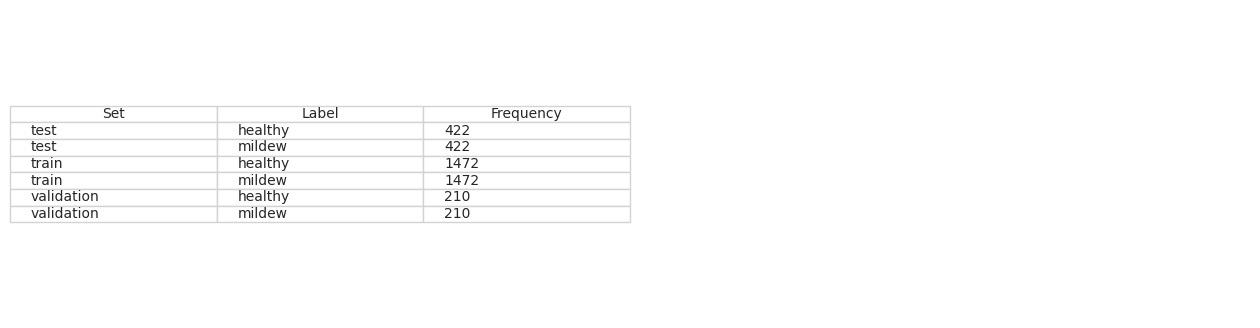

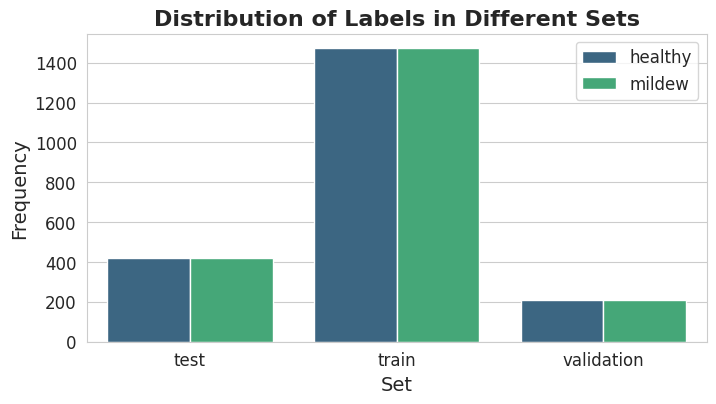

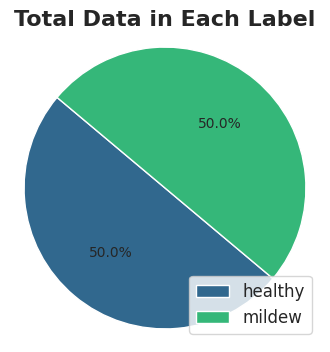

In [16]:
display_data_distribution(dataset_dir, file_path)

---

## Image Augmentation

### Setup Augmentation

**Import Libraries**

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-23 16:44:40.022869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Augmentation Pipeline**

In [18]:
augmentation_data = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    rotation_range=10,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    rescale=1.0/255.0,
)

**Batch Size**

In [19]:
batch_size = 16

**Augmentation Train image Set**

In [20]:
train_set = augmentation_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

**Augmentation Validation image Set**

In [21]:
validation_set = augmentation_data.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

**Augmentation Test image Set**

In [22]:
test_set = augmentation_data.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

### Plot Augmented Images

In [23]:
label_names = {i: label for i, label in enumerate(labels)}
print('Label names:', label_names)


Label names: {0: 'healthy', 1: 'mildew'}


**Augmented Train Image Set**

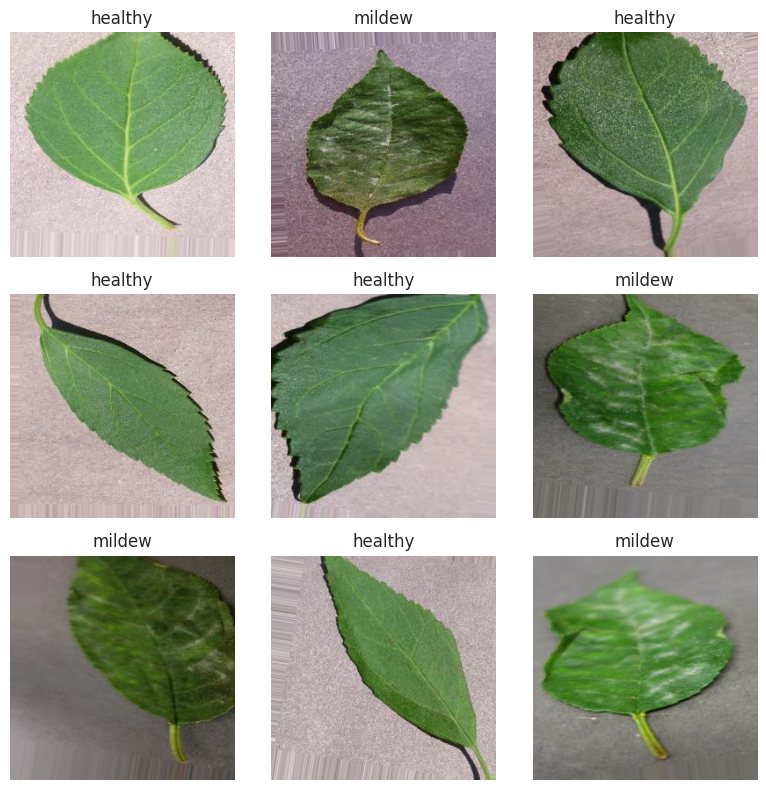

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(train_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Augmented Validation Image Set**

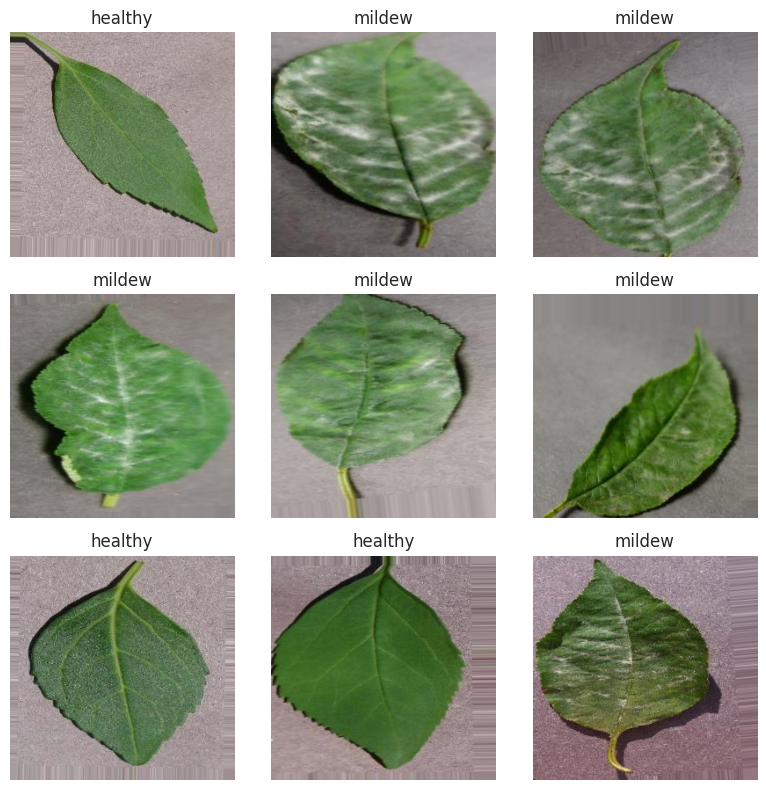

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(validation_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Augmented Test Image Set**

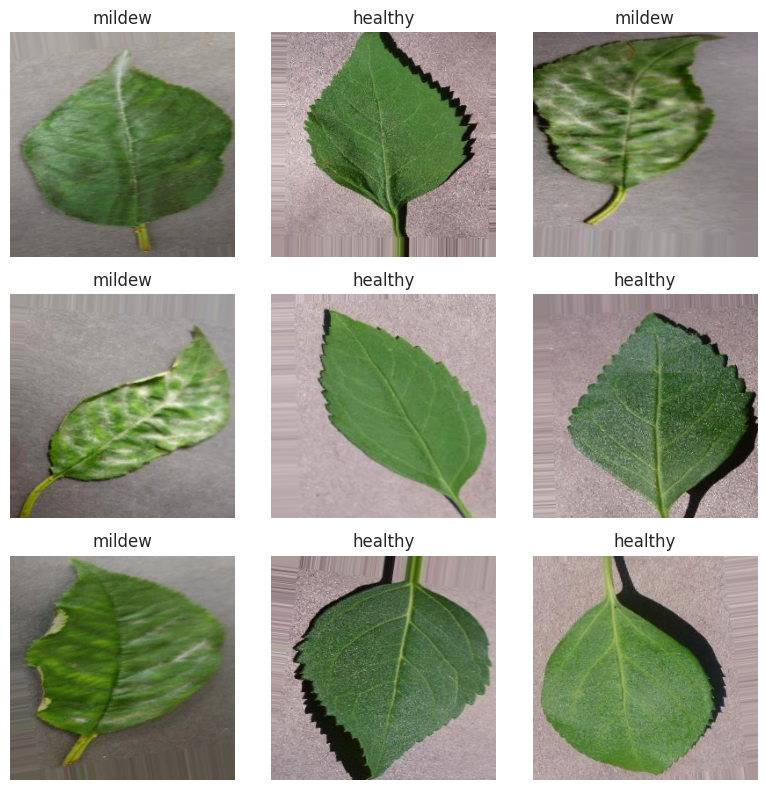

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(test_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Save class_indicies**

In [27]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Building the Model

**Import Model Packages**

In [28]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

### Model

In [29]:
def build_model(image_shape):
    """
    Description:
        Builds a convolutional neural network (CNN) model

    Parameters:
        image_shape - tuple: The shape of input images (height, width, channels)

    Returns:
        model - Sequential: A TensorFlow Keras Sequential model
    """

    model = Sequential()

    # Input Layer
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     input_shape=image_shape,
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layers
    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [32]:
build_model(image_shape).summary()

/workspace/.pip-modules/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,466,177 (28.48 MB)

 Trainable params: 7,466,177 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

**Early Stopping**

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

### Model Training

**Model Summary**

In [36]:
mode = build_model(image_shape)

In [45]:
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 124s 817ms/step - accuracy: 0.7158 - loss: 0.6634 - val_accuracy: 0.9786 - val_loss: 0.0739
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:34 644ms/step - accuracy: 1.0000 - loss: 0.0288

2024-04-22 16:57:40.765023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.9738 - val_loss: 0.0799
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 133s 889ms/step - accuracy: 0.9862 - loss: 0.0441 - val_accuracy: 0.9738 - val_loss: 0.0628
Epoch 4/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 3:34 1s/step - accuracy: 0.9000 - loss: 0.0980

2024-04-22 17:00:01.149288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9000 - loss: 0.0493 - val_accuracy: 0.9952 - val_loss: 0.0315
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 128s 859ms/step - accuracy: 0.9922 - loss: 0.0245 - val_accuracy: 0.9952 - val_loss: 0.0285
Epoch 6/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:29 615ms/step - accuracy: 1.0000 - loss: 0.0100

2024-04-22 17:02:15.100762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9786 - val_loss: 0.0574
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 127s 852ms/step - accuracy: 0.9892 - loss: 0.0295 - val_accuracy: 0.9976 - val_loss: 0.0096
Epoch 8/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:32 634ms/step - accuracy: 1.0000 - loss: 0.0070

2024-04-22 17:04:28.165962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9976 - val_loss: 0.0077
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 118s 793ms/step - accuracy: 0.9889 - loss: 0.0269 - val_accuracy: 0.9976 - val_loss: 0.0094
Epoch 10/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 3:42 2s/step - accuracy: 1.0000 - loss: 7.0626e-04

2024-04-22 17:06:33.399806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 1.0000 - loss: 3.5553e-04 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 11/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 137s 919ms/step - accuracy: 0.9952 - loss: 0.0106 - val_accuracy: 1.0000 - val_loss: 4.7696e-04
Epoch 12/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:28 609ms/step - accuracy: 1.0000 - loss: 2.1856e-04

2024-04-22 17:09:01.221480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 1.0000 - loss: 1.1002e-04 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 13/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 128s 857ms/step - accuracy: 0.9974 - loss: 0.0072 - val_accuracy: 0.9976 - val_loss: 0.0035
Epoch 14/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:32 632ms/step - accuracy: 1.0000 - loss: 3.6651e-04

2024-04-22 17:11:14.957316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 1.0000 - loss: 1.8450e-04 - val_accuracy: 0.9976 - val_loss: 0.0045


**Save Model**

In [46]:
model.save(f'outputs/{version}/mildew_detector_model.h5')

---

## Model Performance

**Model Learning Curve**

In [67]:
losses = pd.DataFrame(model.history.history)

In [68]:
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")

<Figure size 500x400 with 0 Axes>

**Loss**

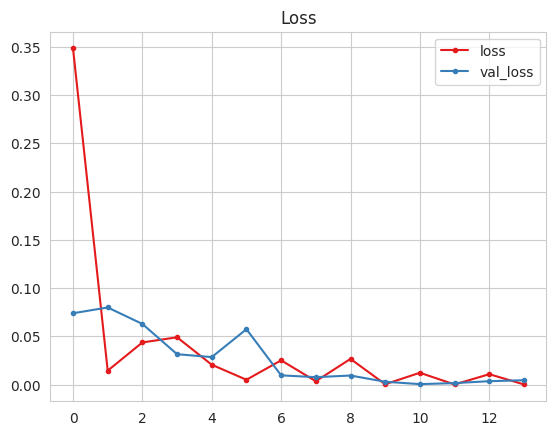

In [74]:
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")

plt.savefig(f'{file_path}/model_loss_training.png',
            bbox_inches='tight', dpi=150)

plt.show()

**Accuracy**

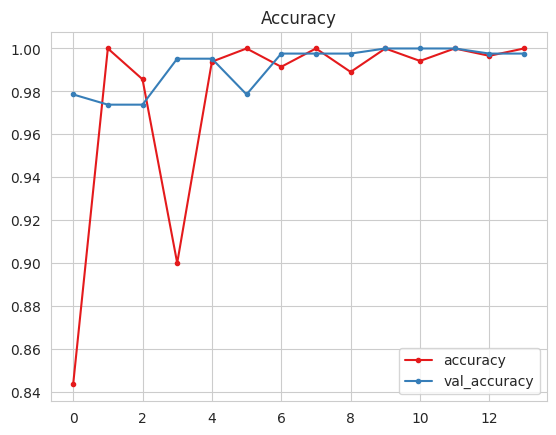

In [73]:
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")

plt.savefig(f'{file_path}/model_accuracy_training.png',
            bbox_inches='tight', dpi=150)

plt.show()

**Loss and Accuracy**

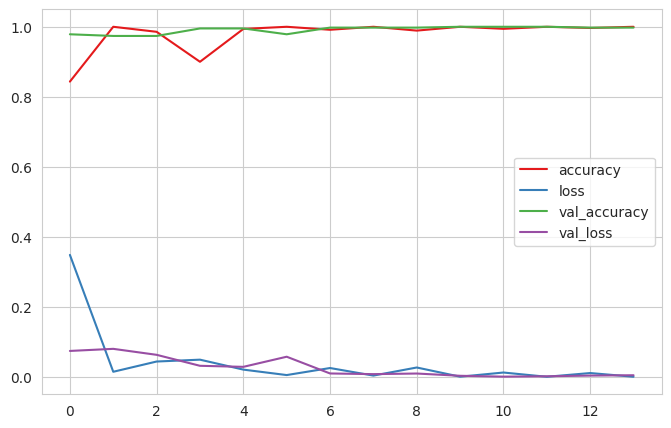

In [72]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))

plt.savefig(f'{file_path}/model_loss_accuracy_training.png',
            bbox_inches='tight', dpi=150)

plt.show()

---

## Model Evaluation

In [75]:
from keras.models import load_model

In [76]:
model = load_model('outputs/v1/mildew_detector_model.h5')

In [77]:
evaluation = model.evaluate(test_set)

/workspace/.pip-modules/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 414ms/step - accuracy: 0.9954 - loss: 0.0166


In [79]:
joblib.dump(value=evaluation,
            filename=f"outputs/{version}/evaluation.pkl")

['outputs/v1/evaluation.pkl']

**Set Variables**

In [81]:
import numpy as np

In [82]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 430ms/step


In [85]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

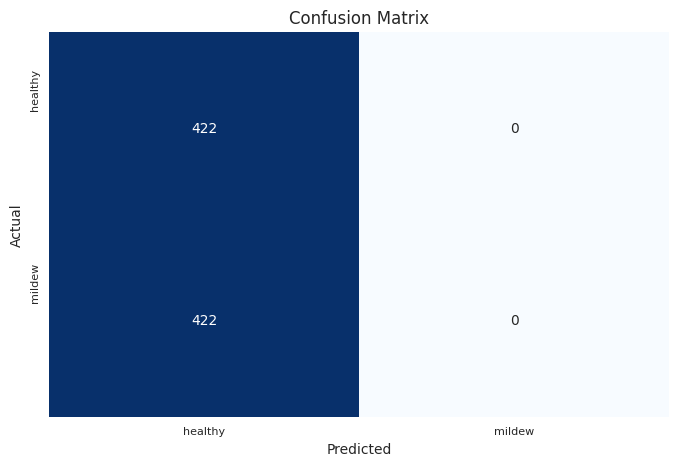

In [94]:
cm = confusion_matrix(y_true, y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

Image shape: (256, 256), Image mode: RGB


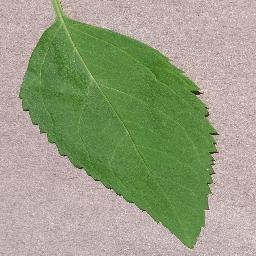

In [90]:
from tensorflow.keras.preprocessing import image
import os

pointer = 44
label = labels[0]

image_path = os.path.join(
    test_path, label, os.listdir(os.path.join(test_path, label))[pointer])

pil_image = image.load_img(image_path,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [91]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


In [92]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
healthy 100.0%
